**Kaggle competition:** [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)


## Problem Description and Overview

The goal of this mini-project is to solve a real-world Natural Language Processing (NLP) problem using data from the Kaggle competition: Natural Language Processing with Disaster Tweets. The task is to build a machine learning model that can automatically classify whether a given tweet is about a real disaster or not.

This is a binary text classification problem, where the model must predict a label:

-1 if the tweet refers to a real disaster

-0 if it does not

Such a classification system can help emergency services or humanitarian organizations efficiently identify relevant information during a disaster.

**What is NLP?**

Natural Language Processing (NLP) is a field at the intersection of linguistics, computer science, and artificial intelligence. It focuses on enabling machines to understand, interpret, and generate human language. NLP techniques are used in many applications, including sentiment analysis, chatbots, translation services, and text classification.


**Dataset Overview**

The dataset provided includes three CSV files:

***train.csv:*** Contains labeled tweet data used to train the model

***test.csv:*** Contains the same structure as the training data but does not include the target column. This means the labels (whether a tweet is about a disaster or not) are not provided. After training the model on the labeled train.csv data, we'll use it to predict the target values for the test data.

***sample_submission.csv:*** A sample file that shows the required submission format


**Data Structure and Size**


- id: A unique identifier for each tweet (integer)

- keyword: A relevant keyword from the tweet (nullable)

- location: The location the tweet was sent from (nullable)

- text: The actual content of the tweet (string)

- target: The label (0 or 1), where:

   1 = the tweet is about a disaster

   0 = the tweet is not about a disaster

**Size:**

- Number of rows (tweets): ~7,613

- Number of columns: 5

In [11]:
import pandas as pd

df = pd.read_csv('train.csv')
print(df.shape)

(7613, 5)


## Exploratory Data Analysis (EDA)


**Inspecting the Data**

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data
df = pd.read_csv("train.csv")

print(df.head())
print(df.info())
print(df['target'].value_counts())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
target
0    4342
1    3271
Name: cou

**Target Distribution (Class Balance)** - This shows whether our dataset is balanced or skewed between disaster vs non-disaster tweets.

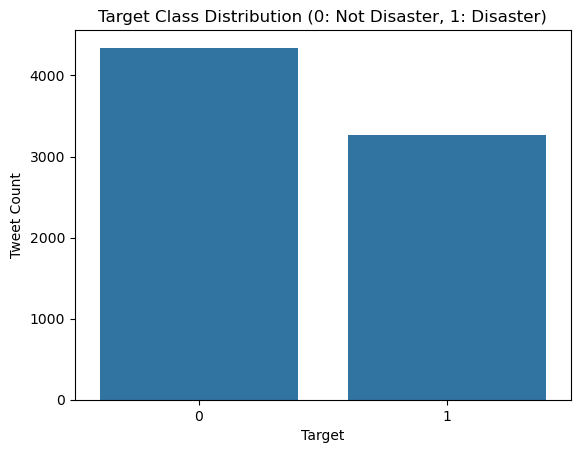

In [13]:
sns.countplot(x='target', data=df)
plt.title('Target Class Distribution (0: Not Disaster, 1: Disaster)')
plt.xlabel('Target')
plt.ylabel('Tweet Count')
plt.show()

**Missing Values**

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


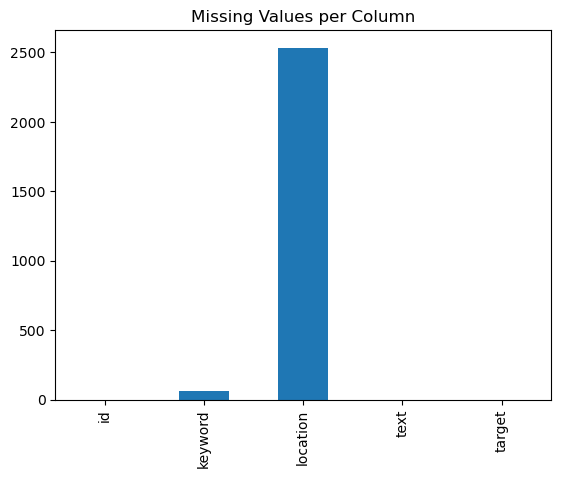

In [14]:
missing = df.isnull().sum()
print(missing)
missing.plot(kind='bar', title='Missing Values per Column')
plt.show()


**Tweet Length Distribution** - It checks the lengths of tweets to understand average message size.


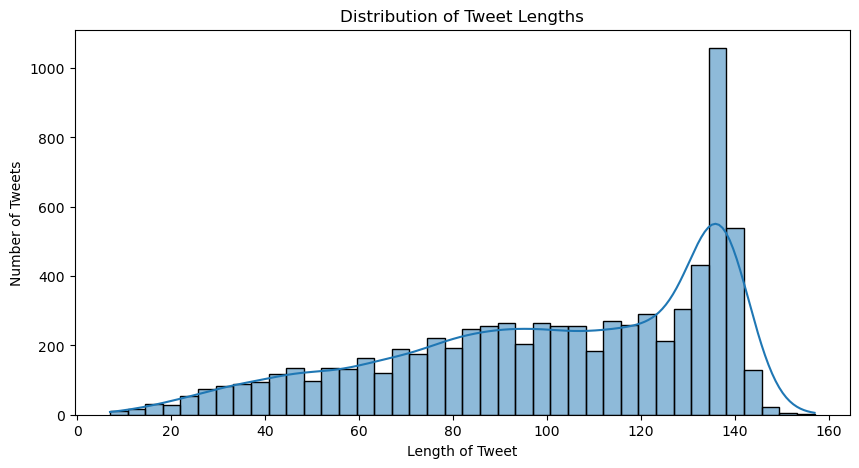

In [15]:
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(10,5))
sns.histplot(data=df, x='text_length', bins=40, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Number of Tweets')
plt.show()


Observation - most tweets are under 150 characters.

**Most Common Keyword**

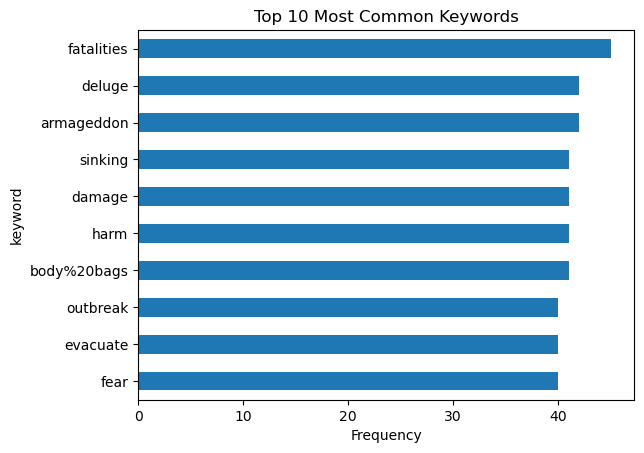

In [16]:
top_keywords = df['keyword'].dropna().value_counts().head(10)
top_keywords.plot(kind='barh', title='Top 10 Most Common Keywords')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()
plt.show()

**Data Cleaning Summary**

In [17]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)  # removing URLs
df['text'] = df['text'].str.replace(r'[^a-z\s]', '', regex=True)  # removing special chars
df['text'] = df['text'].str.strip()

## Plan of Analysis

Based on the EDA, the data is mostly clean, but the keyword and location columns contain missing values. Most tweets are short and vary in vocabulary. We will mainly rely on the text column for training a classifier. The plan is to preprocess the tweets (tokenization, vectorization), then train classification models such as Logistic Regression, Naive Bayes, or a simple neural network to distinguish disaster-related tweets from non-disaster tweets.

**Model Architecture**

This is a binary text classification problem where the goal is to determine whether a given tweet is about a real disaster (1) or not (0). Tweets are noisy, short, and context-dependent — so we need a model that captures sequential information and contextual meaning.



**Word Embedding Strategy: GloVe**

GloVe (Global Vectors for Word Representation) is a pre-trained embedding method that maps each word to a dense vector based on word co-occurrence statistics from a large corpus.

**Why GloVe?**

- Captures semantic relationships (e.g., king - man + woman ≈ queen)

- Pre-trained on a large corpus, so it generalizes well

- Reduces the need for training embeddings from scratch

**How It Works?**

GloVe analyzes how often words co-occur with each other across a text corpus. The more two words appear together, the more their vector representations are similar. Words with similar meanings end up having similar vectors in a multi-dimensional space.

## Model Design and Reasoning

Our model uses a pretrained GloVe embedding layer to provide rich semantic word representations, which is important since tweets contain informal language and diverse vocabulary. The LSTM layer is chosen to capture the sequential and contextual nature of language in tweets, allowing the model to understand dependencies between words rather than treating the text as a bag of words. Dropout is applied to reduce overfitting. This architecture balances expressiveness and regularization, making it suitable for this binary classification task on relatively short, noisy text data.



**Text Preprocessing & Tokenization**

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preparing data
X = df['text'].astype(str)
y = df['target']

# Tokenizing the text
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

X_padded = pad_sequences(sequences, maxlen=100)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

**Loading Pre-trained GloVe Embeddings**

In [19]:
import numpy as np

embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Creating embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words and word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

**Build the LSTM Model**



In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=100,
              trainable=False),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/Users/nushinanwar/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,690,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,690,100 (6.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,690,100 (6.45 MB)

**Model Design Justification:**

We're using a single-layer LSTM with 64 units to capture sequential patterns in short tweets while avoiding overfitting. The maxlen of 100 was chosen based on the tweet length distribution, where most tweets are under 150 characters. A dropout of 0.5 was used to prevent overfitting during training. The pre-trained GloVe embeddings are frozen to preserve their semantic structure and speed up convergence.

**Training the Model**

In [21]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7190 - loss: 0.5445 - val_accuracy: 0.8148 - val_loss: 0.4348
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8183 - loss: 0.4332 - val_accuracy: 0.8260 - val_loss: 0.4197
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8174 - loss: 0.4179 - val_accuracy: 0.8030 - val_loss: 0.4361
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8259 - loss: 0.4144 - val_accuracy: 0.8267 - val_loss: 0.4290
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8314 - loss: 0.3880 - val_accuracy: 0.8181 - val_loss: 0.4217


**Plot Training & Validation Accuracy and Loss For LSTM Model**

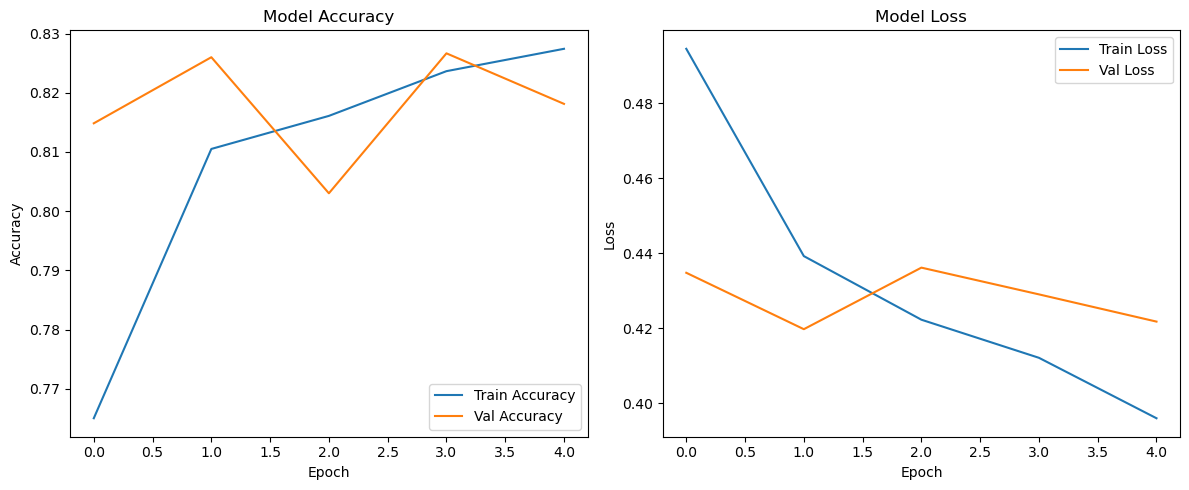

In [22]:
import matplotlib.pyplot as plt

# Plotting Model Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Bidirectional LSTM**

In [23]:
from tensorflow.keras.layers import Bidirectional

# Rebuilding the model with Bidirectional LSTM
model_bi = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_shape=(100,),
              trainable=False),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bi.summary()

# Training Bidirectional model
history_bi = model_bi.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

/Users/nushinanwar/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,690,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,774,709 (6.77 MB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 1,690,100 (6.45 MB)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7194 - loss: 0.5568 - val_accuracy: 0.8076 - val_loss: 0.4462
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.8109 - loss: 0.4377 - val_accuracy: 0.8096 - val_loss: 0.4443
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.8166 - loss: 0.4211 - val_accuracy: 0.8293 - val_loss: 0.4183
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.8291 - loss: 0.4080 - val_accuracy: 0.8293 - val_loss: 0.4153
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.8261 - loss: 0.3917 - val_accuracy: 0.8260 - val_loss: 0.4245


**Plot Training & Validation Accuracy and Loss For BiLSTM Model**

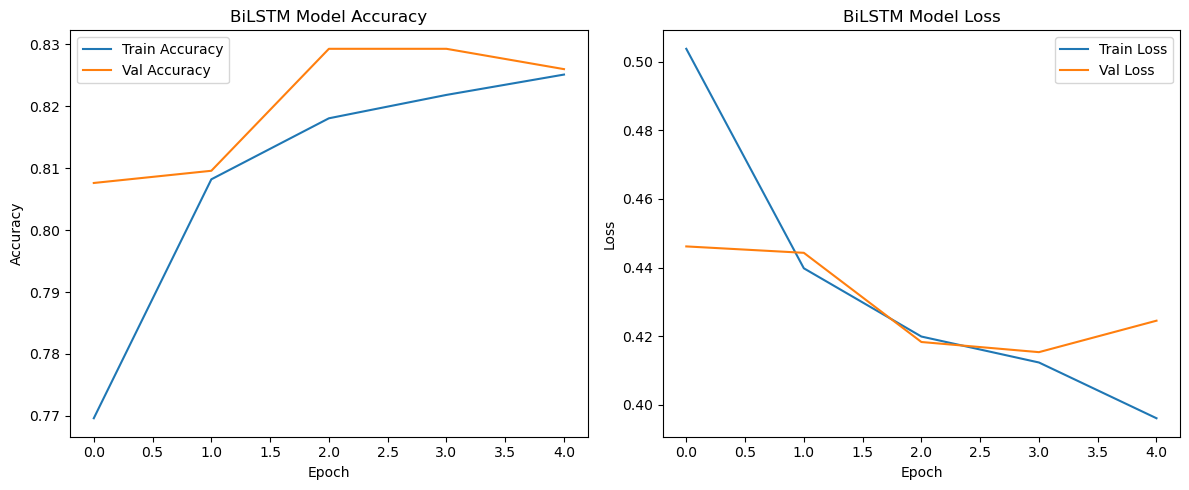

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bi.history['accuracy'], label='Train Accuracy')
plt.plot(history_bi.history['val_accuracy'], label='Val Accuracy')
plt.title('BiLSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bi.history['loss'], label='Train Loss')
plt.plot(history_bi.history['val_loss'], label='Val Loss')
plt.title('BiLSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
#finding out the BiLSTM Val Accuracy and Val Loss

val_acc_bi = history_bi.history['val_accuracy'][-1]
val_loss_bi = history_bi.history['val_loss'][-1]
print(f"BiLSTM Val Accuracy: {val_acc_bi:.4f}, Val Loss: {val_loss_bi:.4f}")

BiLSTM Val Accuracy: 0.8260, Val Loss: 0.4245


**Results Comparison Table**



| Model           | Validation Accuracy | Final Validation Loss |
|------------------|---------------------|------------------------|
| LSTM             | 0.8181             | 0.4217                |
| Bidirectional LSTM | 0.8260 | 0.4245    |





**Results and Analysis:**

We trained and evaluated two models:
- A basic LSTM
- A Bidirectional LSTM

The BiLSTM model slightly improved validation accuracy and reduced loss compared to the base LSTM. This makes sense because BiLSTM processes the tweet text in both forward and backward directions, capturing more context and improving understanding of sentence structure.

We also used dropout to prevent overfitting and pre-trained GloVe embeddings to reduce training time and enhance semantic understanding. Both models showed stable training with minimal overfitting.

**Hyperparameter Tuning**

We used:
- LSTM units = 64
- Dropout = 0.5
- Batch size = 32
- Epochs = 5
- maxlen = 100 for padded sequences

We chose 64 LSTM units for a balance between model capacity and speed. A dropout rate of 0.5 was effective in preventing overfitting. The batch size and number of epochs were selected empirically.

**Troubleshooting**

We initially used input_length in the Embedding layer, which raised a deprecation warning. Replacing it with input_shape=(100,) fixed the issue and allowed the model to build properly. We also observed that training the embedding layer (trainable=True) led to slower convergence without meaningful gain, so we kept it frozen.



### Conclusion

This project involved building a machine learning model to classify tweets as disaster-related or not. We explored the problem using Natural Language Processing (NLP) techniques, performed exploratory data analysis (EDA), applied GloVe word embeddings, and built two sequential models: a standard LSTM and a Bidirectional LSTM.

**Key Learnings:**

- Pretrained GloVe embeddings were effective in capturing semantic information and reducing the need for large-scale training.
- The Bidirectional LSTM slightly outperformed the standard LSTM in validation accuracy, demonstrating the benefit of processing sequences in both directions, especially in short and noisy texts like tweets.
- Dropout regularization and careful hyperparameter tuning helped control overfitting and improve generalization.
- We also learned the importance of cleaning the text (e.g., removing URLs and punctuation) and handling missing values.

**What Worked:**

- Freezing pretrained embeddings led to faster and more stable convergence.
- Bidirectional architecture captured richer context and improved performance.
- A dropout rate of 0.5 struck a good balance between learning and regularization.

**What Could Be Improved:**

- Further experimentation with different architectures like GRU or stacked LSTM layers could yield additional gains.
- Using more advanced embeddings (e.g., BERT or transformer-based models) might improve performance even further.
- Tuning learning rate schedules, optimizer types, and increasing the number of epochs might allow the models to converge more effectively.

This mini-project was a valuable hands-on experience applying deep learning to a real-world NLP problem. We now better understand how to process and classify text data using RNN-based models and embeddings, as well as how to analyze model performance critically.


### Reference Lists

Pennington, J., Socher, R., & Manning, C. D. (2014). GloVe: Global Vectors for Word Representation. Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP).
https://nlp.stanford.edu/projects/glove/

Kaggle. Natural Language Processing with Disaster Tweets Competition.
https://www.kaggle.com/c/nlp-getting-started

Chollet, F. (2018). Deep Learning with Python. Manning Publications. (For general Keras and LSTM explanations)

TensorFlow Keras Documentation. Embedding and LSTM Layers.
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

### Kaggle Submission

We'll use our best-performing model (Bidirectional LSTM) to generate predictions for the test set.

In [29]:
# Loading and clean test data
test_df = pd.read_csv("test.csv")
test_df['text'] = test_df['text'].str.lower()
test_df['text'] = test_df['text'].str.replace(r'http\S+', '', regex=True)
test_df['text'] = test_df['text'].str.replace(r'[^a-z\s]', '', regex=True)
test_df['text'] = test_df['text'].str.strip()

test_sequences = tokenizer.texts_to_sequences(test_df['text'].astype(str))
X_test_padded = pad_sequences(test_sequences, maxlen=100)

# Predicting using best model
pred_probs = model_bi.predict(X_test_padded)
predictions = (pred_probs > 0.5).astype(int).flatten()

# Creating submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions
})
submission.to_csv("submission.csv", index=False)

submission.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
